# Library

In [1]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
tf.random.set_seed(42)

from typing import List, Set, Dict, Tuple, Optional, Any
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
import shap
shap.initjs()

print('tf:', tf.__version__)
print('shap:', shap.__version__)

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.metrics import mean_squared_error as mse

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime
from tqdm.notebook import tqdm

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import SimpleRNN, GRU
from tensorflow.keras.layers import Dropout, InputLayer, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for i in range(len(gpus)):
            tf.config.experimental.set_memory_growth(gpus[i], True)
    except RuntimeError as e:
        print(e)

Instructions for updating:
non-resource variables are not supported in the long term


tf: 2.5.0
shap: 0.41.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
# LSTM
def LSTM_model():
    lstm = Sequential()
    lstm.add(InputLayer(input_shape=(x.shape[1],x.shape[2])))
    lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
    lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
    lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(units=1, activation='sigmoid'))
    lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), 
                 loss = "binary_crossentropy", metrics=['acc'])
    return lstm

In [3]:
# LSTM modeling

path = '/project/LSH/** 해외_Journal of Biomedical Informatics/'
with tf.device('/device:GPU:0'):

    # 1. Data load
    x = np.load(path + 'x_(7727,10,3595).npy')
    y = np.load(path + 'y_(7727,1).npy')
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
    
    acc_list, precision_list, recall_list, f1_list, auc_list = [], [], [], [], []
    result = []
    
    model = LSTM_model()
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=False)
    model.fit(X_train, y_train, epochs=300, batch_size=516, validation_split=0.25, callbacks=[early_stop])

    y_pred_test = model.predict(X_test)
    y_pred_test[y_pred_test>0.5]=1
    y_pred_test[y_pred_test<=0.5]=0

    acc = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    roc_auc = roc_auc_score(y_test, y_pred_test)

    result.append(['LSTM', acc, precision, recall, f1, roc_auc])

Train on 4635 samples, validate on 1546 samples
Epoch 1/300
4635/4635 [==============================] - ETA: 0s - loss: 0.7220 - acc: 0.4682

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


4635/4635 [==============================] - 2s 453us/sample - loss: 0.7220 - acc: 0.4682 - val_loss: 0.6713 - val_acc: 0.6080
Epoch 2/300
4635/4635 [==============================] - 1s 216us/sample - loss: 0.6815 - acc: 0.6086 - val_loss: 0.6794 - val_acc: 0.6080
Epoch 3/300
4635/4635 [==============================] - 1s 213us/sample - loss: 0.6754 - acc: 0.6112 - val_loss: 0.6695 - val_acc: 0.6080
Epoch 4/300
4635/4635 [==============================] - 1s 216us/sample - loss: 0.6719 - acc: 0.6052 - val_loss: 0.6700 - val_acc: 0.6080
Epoch 5/300
4635/4635 [==============================] - 1s 217us/sample - loss: 0.6718 - acc: 0.6104 - val_loss: 0.6693 - val_acc: 0.6080
Epoch 6/300
4635/4635 [==============================] - 1s 216us/sample - loss: 0.6729 - acc: 0.6110 - val_loss: 0.6694 - val_acc: 0.6080
Epoch 7/300
4635/4635 [==============================] - 1s 215us/sample - loss: 0.6729 - acc: 0.6140 - val_loss: 0.6690 - val_acc: 0.6080
Epoch 8/300
4635/4635 [================

In [4]:
result

[['LSTM',
  0.7574385510996119,
  0.7855670103092783,
  0.8202368137782562,
  0.8025276461295417,
  0.7415608704223534]]

In [5]:
X_train.shape

(6181, 10, 3595)

In [6]:
# SHAP for LSTM

with tf.device('/device:GPU:0'):    
    
    # Option 1) Extracting Sample Data 
    n_sample = 100
    sample_data = X_train[np.random.choice(X_train.shape[0], n_sample, replace=False)] 
    
    # Option 2) All Data -> X_train
    explainer = shap.DeepExplainer(model, sample_data)
    shap_values = explainer.shap_values(sample_data)

Using TensorFlow backend.
keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [8]:
sample_data # background

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 1., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        ...,
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

In [7]:
shap_val = np.array(shap_values).reshape(100, 10, 3595)
shap_val.shape

(100, 10, 3595)

In [54]:
shap_val[:,:,0]

array([[ 0.00134514,  0.00251439,  0.00355402,  0.00513543,  0.00673665,
         0.00838052, -0.00313677, -0.00294823, -0.00213331, -0.00101604],
       [ 0.00184228,  0.00346447,  0.00493128,  0.00725796,  0.00962786,
         0.01231773, -0.00469211, -0.0044975 , -0.00341159, -0.00187941],
       [-0.00109648, -0.00166441, -0.00218392, -0.00214029, -0.00239707,
        -0.00169104, -0.00139434, -0.0014517 , -0.00117441, -0.00089398],
       [-0.00170512, -0.0023446 , -0.003167  , -0.00334384, -0.0032871 ,
        -0.0031217 , -0.00288331, -0.00245932, -0.00195351, -0.00108093],
       [-0.00077972, -0.00119646, -0.00157447, -0.00153233, -0.0017339 ,
        -0.00131302, -0.00117224, -0.00131512, -0.00114768, -0.00092204],
       [ 0.0016479 ,  0.00308205,  0.00437149,  0.00636608,  0.00842274,
        -0.00401992, -0.00389321, -0.00357779, -0.00269252, -0.00144589],
       [-0.00142255, -0.00215271, -0.00289892, -0.00301054, -0.00344267,
        -0.0026401 , -0.00231518, -0.00241728

In [47]:
a = shap_val[0]
a.shape

(10, 3595)

In [63]:
shap_values[0].shape

(100, 10, 3595)

In [68]:
agg_shap_values.shape
agg_data.shape

(100, 3595)

(100, 3595)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



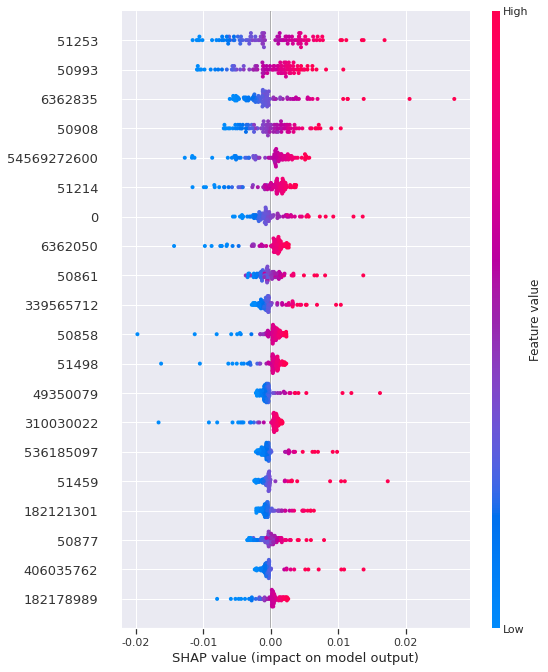

In [66]:
# Combine shap_values for time series elements (average)
# https://github.com/slundberg/shap/issues/803

def aggregate_shap_values(data, shap_values):
    shap_array = np.array(shap_values[0]) # array of shap values computed for time series

    mean_shaps = []

    for i in range(shap_array.shape[0]):
        max_seq_length = shap_array.shape[1]
        for k in range(shap_array.shape[1]):
            if i != 0 and k != 0:  # buggy index I skip over
                # boolean check for zeroed out padded rows
                all_zero = not np.all(data[i, k, ] == 0)
                if all_zero:  # if row k is all zero
                    max_seq_length = k
        mean_shaps.append(shap_array[i, :max_seq_length, :].mean(axis=0).tolist())
    shap_values = np.array(mean_shaps)
    return shap_values

agg_shap_values = aggregate_shap_values(shap_val, shap_values)
# Also combine shap_val (average)
agg_data = np.array(shap_val.mean(axis=1))

COLS = list(pd.read_csv('/project/LSH/total_data.csv')['ITEMID'].sort_values().unique())

# shap.summary_plot(
#     agg_shap_values, agg_data, 
#     feature_names=COLS, plot_type="bar")

shap.summary_plot(
    agg_shap_values, agg_data, 
    feature_names=COLS
)